# One Jupyter notebook. From GeoJSON to .xml 

## Imports

In [5]:
import json
import geojson 
import geopandas
import pandas as pd
import numpy as np
import os
import datetime as dt

from lmd.lib import Collection, Shape
from lmd import tools
from PIL import Image
from lmd.lib import SegmentationLoader

import tifffile
import string

from shapely.geometry import Point, LineString

import datetime as dt
datetime = dt.datetime.today().strftime("%Y%m%d_%H%M%S")

## From GeoJSON to Dataframe

In [14]:
#user defined variables:
path_to_file = '/Users/jnimoca/Jose_BI/Repositories/Qupath_to_LMD/example_input/test_input.geojson'
path_to_save_files = '/Users/jnimoca/Jose_BI/Repositories/Qupath_to_LMD/example_output/'
#the naming of these should match exactly the names in the geoJSON file
calibration_points = ['calib12','calib13','calib20']

### Samples and wells

In [7]:
# if you want to pass a custom well loadout use the following dictionary:  
# The dictionary keys will have to be the class name used in qupath, it has to be the exact names.  
# please choose wells with a 2-row 2-column margin. not rows (A, B, N, O) not columns (1,2,23,24)  

In [113]:
samples_and_wells = { 
 '187_HBC_mid_3': 'C3',
 '187_HBC_nVEC_1': 'C4',
 '187_HBC_nVEC_2': 'C5',
 '187_HBC_mid_2': 'C6',
 '187_HBC_nTroph_3': 'C7',
 '187_HBC_nTroph_1': 'C8',
 '187_HBC_mid_1': 'C9',
 '187_HBC_nVEC_3': 'C10',
 '187_HBC_nTroph_2': 'C11',
 '108_STB_nVEC_1': 'F3',
 '108_STB_nVEC_2': 'F4',
 '108_STB_nVEC_3': 'F5',
 '108_STB_gen_1': 'F6',
 '108_STB_gen_2': 'F7',
 '108_STB_gen_3': 'F8',
 '108_CTB_1_1': 'F9',
 '108_CTB_2_1': 'F10',
 '108_CTB_3_1': 'F11',
 '108_HBC_nTroph_1': 'G3',
 '108_HBC_nTroph_2': 'G4',
 '108_HBC_nTroph_3': 'G5',
 '108_HBC_nVEC_1': 'G6',
 '108_HBC_nVEC_2': 'G7',
 '108_HBC_nVEC_3': 'G8',
 '108_HBC_mid_1': 'G9',
 '108_HBC_mid_2': 'G10',
 '108_HBC_mid_3': 'G11',
 '108_CCT_1': 'H3',
 '108_CCT_2': 'H4',
 '108_CCT_3': 'H5',
 '108_VEC_1': 'H6',
 '108_VEC_2': 'H7',
 '108_VEC_3': 'H8',
 '108_Str_1': 'H9',
 '108_Str_2': 'H10',
 '108_Str_3': 'H11',
 '187_STB_nVEC_1': 'D3',
 '187_STB_nVEC_2': 'D4',
 '187_STB_nVEC_3': 'D5',
 '187_STB_gen_1': 'D6',
 '187_STB_gen_2': 'D7',
 '187_STB_gen_3': 'D8',
 '187_CTB_1': 'D9',
 '187_CTB_2': 'D10',
 '187_CTB_3': 'D11',
 '187_CCT_1': 'E3',
 '187_CCT_2': 'E4',
 '187_CCT_3': 'E5',
 '187_VEC_1': 'E6',
 '187_VEC_2': 'E7',
 '187_VEC_3': 'E8',
 '187_str_1': 'E9',
 '187_str_2': 'E10',
 '187_str_3': 'E11'
 }

## Code

### process dataframe

### Utilities

In [10]:
#utilities

#Create a datafrate for polygons with a specific name, if it contains a string

def filter_table_by_name(df, string):
    new_df = df.copy()
    new_df = new_df[new_df['Name'].str.contains(string)]
    return new_df

#list all geoJSON files in a given path
def list_geoJSON_in_path(path):
    filelist = os.listdir(path)
    #filter the files so there are only images
    filelist =  [x for x in filelist if '.geojson' in x]
    return filelist

### Pipe from dataframe to xml

In [11]:
def dataframe_to_xml_v2(input_file, output_path):
    
    #create the collection of py-lmd-env package
    #uses caliblist passed on the function, order matters
    #orientation vector is for QuPath coordenate system
    the_collection = Collection(calibration_points = caliblist)
    the_collection.orientation_transform = np.array([[1,0 ], [0,-1]])
    print('\nusing simplified shapes')
    for i in clean_df.index:
        the_collection.new_shape(clean_df.at[i,'lol_simple'], 
                                    well = samples_and_wells[clean_df.at[i, "Name"]])
    

    #save collection as xml
    print('these are your calibration point coordenates')
    output_name= os.path.join(output_path,f'{datetime}_contours.xml')
    the_collection.save(output_name)
    
    #________________________________________________________
    #Information for user
    #________________________________________________________
    
    #create and export dataframe with sample placement in 384 well plate
    rows_A_P= [i for i in string.ascii_uppercase[:16]]
    columns_1_24 = [str(i) for i in range(1,25)]
    df_wp384 = pd.DataFrame(0,columns=columns_1_24, index=rows_A_P)
    
    for i in samples_and_wells:
        location = samples_and_wells[i]
        df_wp384.at[location[0],location[1:]] = i
    df_wp384_output_name = os.path.splitext(output_path)[0]+f'{datetime}_384_wellplate.csv'
    print('\n csv file of 384 well plate positions, saved as: ')
    print(df_wp384_output_name)
    df_wp384.to_csv(df_wp384_output_name, index=True)
    
    #print statistics about collection
    print('')
    print(the_collection.stats())
    #plot diagram of all shapes with calibpoints
    the_collection.plot(calibration = True)    
    
    #print where file was saved
    print('\n xml file saved as: ')
    print(output_name)
    
    #create a printlist of all classes, with their wells, and the number of contours 
    printlist = []
    for i in clean_df.Name.unique():
        sublist=[]
        sublist.append(i)
        sublist.append(samples_and_wells[i])
        sublist.append(clean_df[clean_df.Name == i]['Name'].shape[0])
        printlist.append(sublist)
    
    #print the printlist in a human readable format
    print('\n')
    print('Sample','-----------','Well','--','How many contours\n')
    #sort for the order of the class name
    printlist.sort(key=lambda x: x[0])
    for i in range(len(printlist)):
        if printlist[i][0] in list(clean_df.Name):
            space1_number = 18 - len(printlist[i][0])
            space1 = '-' * int(space1_number)
            space2_number = 5 - len(printlist[i][1])
            space2 = '-' * int(space2_number)
            print(printlist[i][0], space1, printlist[i][1], space2, printlist[i][2])

## Processing from GeoJSON to Dataframe

you have 3 NaNs in your classification column
these are unclassified objects from Qupath, they will be ignored
samples_and_wells was preloaded, using it for assigning wells

using simplified shapes
these are your calibration point coordenates
[1134379. -690013.]
[  963517. -1476484.]
[   64212. -1410367.]


/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_4555/955842347.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '187_HBC_mid_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i,'Name'] = tmp
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_4555/2404525167.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '187_HBC_mid_3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_wp384.at[location[0],location[1:]] = i
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_4555/2404525167.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '187_HBC_nVEC_1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_wp384.at[location[0


 csv file of 384 well plate positions, saved as: 
/Users/jnimoca/Jose_BI/Repositories/Qupath_to_LMD/example_output/20231201_123441_384_wellplate.csv

===== Collection Stats =====
Number of shapes: 2,110
Number of vertices: 29,484
Mean vertices: 14
Min vertices: 9
5% percentile vertices: 10
Median vertices: 13
95% percentile vertices: 20
Max vertices: 30
None


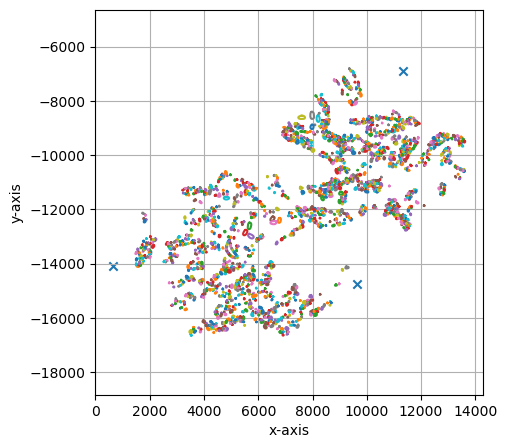


 xml file saved as: 
/Users/jnimoca/Jose_BI/Repositories/Qupath_to_LMD/example_output/20231201_123441_contours.xml


Sample ----------- Well -- How many contours

187_CTB_1 --------- D9 --- 111
187_CTB_2 --------- D10 -- 111
187_CTB_3 --------- D11 -- 111
187_HBC_mid_1 ----- C9 --- 131
187_HBC_mid_2 ----- C6 --- 129
187_HBC_mid_3 ----- C3 --- 128
187_HBC_nTroph_1 -- C8 --- 152
187_HBC_nTroph_2 -- C11 -- 152
187_HBC_nTroph_3 -- C7 --- 151
187_HBC_nVEC_1 ---- C4 --- 94
187_HBC_nVEC_2 ---- C5 --- 94
187_HBC_nVEC_3 ---- C10 -- 93
187_STB_gen_1 ----- D6 --- 54
187_STB_gen_2 ----- D7 --- 53
187_STB_gen_3 ----- D8 --- 53
187_STB_nVEC_1 ---- D3 --- 42
187_STB_nVEC_2 ---- D4 --- 42
187_STB_nVEC_3 ---- D5 --- 40
187_VEC_1 --------- E6 --- 120
187_VEC_2 --------- E7 --- 120
187_VEC_3 --------- E8 --- 119
187_str_1 --------- E9 --- 4
187_str_2 --------- E10 -- 3
187_str_3 --------- E11 -- 3


In [15]:
#options: 
#write down batch=True inside parentheses if you are processing a series of files
dataframe_to_xml_v2(input_file=path_to_file, output_path=path_to_save_files)

In [111]:
# 1 load and QC geojson file
def load_and_QC_geojson_file(geojson_path: str, list_of_calibpoint_names: list = ['calib1','calib2','calib3']):

    #load geojson file
    df = geopandas.read_file(path_to_file)

    #save calib points in a list
    caliblist = []
    for point_name in list_of_calibpoint_names:
        if point_name in df['name'].unique():
            caliblist.append(df.loc[df['name'] == point_name, 'geometry'].values[0])
        else:
            st.write('Your given name is not present in the file', 
            f'These are the calib points you passed: {list_of_calibpoint_names}',
            f"These are the calib points found in the geojson you gave me: {df['name'].unique()}")
    #create coordenate list
    listarray = []
    for point in pointlist:
        listarray.append([point.x, point.y])
    calib_np_array = np.array(listarray)

    #now that calibration points are saved, remove them from the dataframe
    df = df[df['name'].isin(list_of_calibpoint_names) == False]

    #check and remove empty classifications 
    if df['classification'].isna().sum() !=0 :
        st.write(f"you have {df['classification'].isna().sum()} NaNs in your classification column",
                "these are unclassified objects from Qupath, they will be ignored") 
        df = df[df['classification'].notna()]

    #check for MultiPolygon objects
    if 'MultiPolygon' in df.geometry.geom_type.value_counts().keys():
        st.write('MultiPolygon objects present:',
        #print out the classification name of the MultiPolygon objects
        f"{df[df.geometry.geom_type == 'MultiPolygon']['classification']}", 
        'these are not supported, please convert them to polygons in Qupath',
        'the script will continue but these objects will be ignored')
        #remove MultiPolygon objects
        df = df[df.geometry.geom_type != 'MultiPolygon']

    # reformat shape coordenate list
    df['coords'] = np.nan
    df['coords'] = df['coords'].astype('object')
    # simplify to reduce number of points
    df['simple'] = df.geometry.simplify(1)
    for i in df.index:
        geom=df.at[i, 'simple']
        tmp = list(geom.exterior.coords)
        tmp_lol = [list(i) for i in tmp]
        df.at[i,'coords'] = tmp_lol

    #extract classification name into a new column
    df['Name'] = np.nan
    for i in df.index:
        tmp = df.classification[i].get('name')
        df.at[i,'Name'] = tmp

    st.write('The file loading is complete')

    return(df,calib_np_array)

In [ ]:
# 2 parse and check samples and wells
def load_and_QC_SamplesandWells(samples_and_wells_input, df):

    # parse common human copy paste formats
    # remove newlines
    samples_and_wells_processed = samples_and_wells_input.replace("\n", "")
    # remove spaces
    samples_and_wells_processed = samples_and_wells_processed.replace(" ", "")
    #parse into python dictionary
    samples_and_wells = ast.literal_eval(samples_and_wells_processed)

    #create list of acceptable wells, default is using a space in between columns
    list_of_acceptable_wells =[]
    for row in list(string.ascii_uppercase[2:14]):
        for column in range(2,22):
            list_of_acceptable_wells.append(str(row) + str(column))

    #check for improper wells
    for well in samples_and_wells.values():
        if well not in list_of_acceptable_wells:
            st.write(f'Your well {well} is not in the list of acceptable wells, please correct it',
            'the LMD is not able to collect into this well, the script will stop here')
            st.stop()

    #check that names in df are all present in the samples and wells
    for name in df.Name.unique():
        if name not in samples_and_wells.keys():
            st.write(f'Your name {name} is not in the list of samples_and_wells, please correct either',
            'please change the class name in Qupath or add it to the samples_and_wells dictionary',
            'and then rerun the web app')
            st.stop()
    
    return samples_and_wells

In [ ]:
# 3 create collection
def create_collection(df = df, calib_np_array = calib_np_array, samples_and_wells = samples_and_wells ):
    #create the collection of py-lmd-env package
    #uses caliblist passed on the function, order matters
    #orientation vector is for QuPath coordenate system
    the_collection = Collection(calibration_points = calib_np_array)
    the_collection.orientation_transform = np.array([[1,0 ], [0,-1]])
    for i in df.index:
        the_collection.new_shape(df.at[i,'coords'], well = samples_and_wells[df.at[i, "Name"]])

    the_collection.plot(save_name= "./TheCollection.png")
    st.image("./TheCollection.png", caption='Your Contours', use_column_width=True)
    st.write(the_collection.stats())
    
    the_collection.save(f"./{datetime}_LMD_ready_contours.xml")
    st.download_button("Download file", Path(f"./{datetime}_LMD_ready_contours.xml").read_text(), f"./{datetime}_LMD_ready_contours.xml")
    
    #create and export dataframe with sample placement in 384 well plate
    rows_A_P= [i for i in string.ascii_uppercase[:16]]
    columns_1_24 = [str(i) for i in range(1,25)]
    df_wp384 = pd.DataFrame('',columns=columns_1_24, index=rows_A_P)
    #fill in the dataframe with samples and wells
    for i in samples_and_wells:
        location = samples_and_wells[i]
        df_wp384.at[location[0],location[1:]] = i

    if st.button('Download 384 well plate layout'):
        df_wp384.to_csv(f"./{datetime}_384_wellplate.csv", index=True)
        st.write('Your 384 well plate layout has been downloaded')
